<a href="https://colab.research.google.com/github/HITBEATKICK/-/blob/main/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5_FFT%EC%99%80_CNN%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%ED%9A%8C%EC%A0%84%EA%B8%B0%EA%B3%84_%EA%B3%A0%EC%9E%A5%EA%B0%90%EC%A7%80_%EB%B0%8F_%EC%98%88%EC%B8%A1_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98_%EA%B0%9C%EB%B0%9C_%EA%B8%B0%EA%B3%84%EC%8B%9C%EC%8A%A4%ED%85%9C%EB%94%94%EC%9E%90%EC%9D%B8%EA%B3%B5%ED%95%99%EA%B3%BC_22110034_%EC%9D%B4%EC%84%9C%EC%A4%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **개요**

**FFT와 CNN을 이용한 회전기계 고장감지 및 예측 알고리즘 개발**

데이터셋: KAMP 인공지능 중소벤처 제조 플랫폼 (회전기계 고장유형 AI 데이터셋)

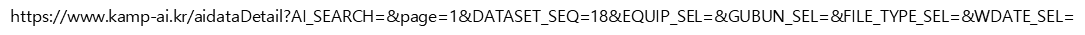

진동센서를 이용한 기계고장 진단은 현재 많은 연구가 이뤄지고있다.

진동센서로 받은 가속도 데이터를 바로 이용해 CNN 학습 시키는 방법, cwt를 이용해 2차원 CNN 학습을 시키는 방법 등등 여러가지 방법이 있지만 본 알고리즘은 FFT 분석만을 이용한 데이터와 1차원 CNN을 이용해 더욱 효과적인 성능을 보인 알고리즘을 개발하였다.

가속도 데이터인 시계열 데이터를 1차원 CNN 시키게 되면 정확도가 비교적 낮고 cwt등 주파수-시간-amplitude를 한 이미지와 2차원 CNN 분석을 이용한 기법은 데이터가 무겁고 많은 메모리를 소모한다는 치명적 단점이 있다.

따라서 FFT 주파수 분석과 1차원 CNN을 이용한 방법은 정확도와 사용성에 대한 이점을 모두 가지고 있어 기계고장을 분류하는데 유용함을 보인다.

본 알고리즘은 많은 기계고장의 예시가 되는 회전기계 고장유형 데이터셋을 이용한다.

**회전기계**

회전속도: 1500RPM

데이터 개수: 센서당 약 190,000개

sampling rate: 약 1360Hz

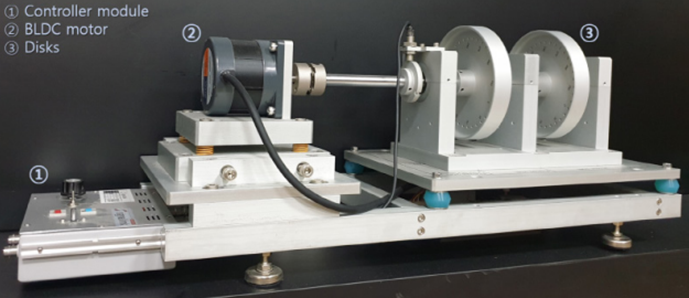

**센서**

스마트진동센서-시그널링크

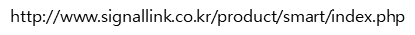

Z축 데이터만 수집

실험 시간: 약 140초

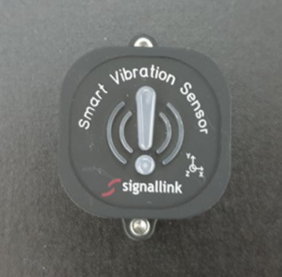

**센서 부착 위치 및 유형 분류**

Normal(정상 상태)

Type1(질량 불균형): Disk2의 편심질량 추가

Type2(지지 불량): Support3의 미흡한 볼트 체결

Type3(질량 불균형과 지지 불량)

순서대로 1,7,8,9 위치 센서 네개 부착

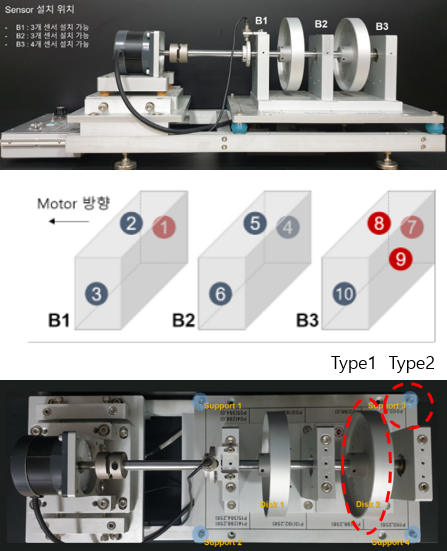

# **코드**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***전처리***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft

데이터 불러오기

In [ ]:
path = "/content/drive/MyDrive/디스커버리_프로그래밍대회/data/"
names = ['g1_sensor1.csv', 'g1_sensor2.csv', 'g1_sensor3.csv', 'g1_sensor4.csv']

sensor1 = pd.read_csv(path + names[0], names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor2 = pd.read_csv(path + names[1], names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor3 = pd.read_csv(path + names[2], names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor4 = pd.read_csv(path + names[3], names = ['time', 'normal', 'type1', 'type2', 'type3'])

선형보간:

센서마다의 sampling rate가 달라 일정한 길이의 선형보간 필요

In [ ]:
from scipy import interpolate
x_new = np.arange(0, 140, 0.001)
y_new1 = []; y_new2 = []; y_new3 = []; y_new4 = []
for item in ['normal', 'type1', 'type2', 'type3']:
 f_linear1 = interpolate.interp1d(sensor1['time'], sensor1[item], kind='linear'); y_new1.append(f_linear1(x_new))
 f_linear2 = interpolate.interp1d(sensor2['time'], sensor2[item], kind='linear'); y_new2.append(f_linear2(x_new))
 f_linear3 = interpolate.interp1d(sensor3['time'], sensor3[item], kind='linear'); y_new3.append(f_linear3(x_new))
 f_linear4 = interpolate.interp1d(sensor4['time'], sensor4[item], kind='linear'); y_new4.append(f_linear4(x_new))

계산을 편하게 하기위한 데이터 슬라이싱 (센서마다 데이터 10만개씩 사용)

In [ ]:
sensor1 = pd.DataFrame(np.array(y_new1).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor2 = pd.DataFrame(np.array(y_new2).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor3 = pd.DataFrame(np.array(y_new3).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor4 = pd.DataFrame(np.array(y_new4).T, columns = ['normal', 'type1', 'type2', 'type3'])

sensor1 = sensor1[30000:130000][:]
sensor2 = sensor2[30000:130000][:]
sensor3 = sensor3[30000:130000][:]
sensor4 = sensor4[30000:130000][:]

sensor1_normal = sensor1.iloc[:,[0]]
sensor1_type1 = sensor1.iloc[:,[1]]
sensor1_type2 = sensor1.iloc[:,[2]]
sensor1_type3 = sensor1.iloc[:,[3]]

sensor2_normal = sensor2.iloc[:,[0]]
sensor2_type1 = sensor2.iloc[:,[1]]
sensor2_type2 = sensor2.iloc[:,[2]]
sensor2_type3 = sensor2.iloc[:,[3]]

sensor3_normal = sensor3.iloc[:,[0]]
sensor3_type1 = sensor3.iloc[:,[1]]
sensor3_type2 = sensor3.iloc[:,[2]]
sensor3_type3 = sensor3.iloc[:,[3]]

sensor4_normal = sensor4.iloc[:,[0]]
sensor4_type1 = sensor4.iloc[:,[1]]
sensor4_type2 = sensor4.iloc[:,[2]]
sensor4_type3 = sensor4.iloc[:,[3]]

normal = pd.concat([sensor1_normal, sensor2_normal, sensor3_normal, sensor4_normal], axis=1)
type1 = pd.concat([sensor1_type1, sensor2_type1, sensor3_type1, sensor4_type1], axis=1)
type2 = pd.concat([sensor1_type2, sensor2_type2, sensor3_type2, sensor4_type2], axis=1)
type3 = pd.concat([sensor1_type3, sensor2_type3, sensor3_type3, sensor4_type3], axis=1)

In [ ]:
print(normal)
print(type1)
print(type2)
print(type3)

          normal    normal    normal    normal
30000   0.529780  0.036818  0.083832 -0.383974
30001   0.428385 -1.059378  0.206478 -0.574085
30002   0.565759  0.286140  0.045089 -1.277069
30003  -0.123977  0.677639  0.098550 -0.966330
30004   0.302458  0.380924 -0.071771 -1.488627
...          ...       ...       ...       ...
129995  0.464819  0.063284 -0.347285  1.423282
129996  1.029037  1.140935 -0.361625  1.338108
129997  0.782089  0.796828 -0.342002  1.091096
129998  0.392861 -0.303488  0.092981  0.679341
129999  0.954217  0.267276 -0.251055  0.527843

[100000 rows x 4 columns]
           type1     type1     type1     type1
30000   0.484928 -1.072262  0.092055  0.238158
30001  -0.012238 -1.737809 -0.329721  0.363218
30002   0.076892 -0.526225  0.150924  0.596324
30003  -0.685212 -1.014568  0.408669  0.118753
30004  -0.561738 -0.530346 -0.385068  0.516754
...          ...       ...       ...       ...
129995 -1.539176  2.291972 -0.190703  1.021326
129996 -2.279611  1.523399  0.065

FFT 변환 데이터 저장을 위한 변수 설정 및 리스트 생성

In [ ]:
# Sampling rate과 회전속도를 기반으로 한 회전당 데이터 포인트 수 계산
rpm = 1500
sampling_rate = 1000
rev_per_sec = rpm / 60
data_points_per_rev = int(sampling_rate / rev_per_sec)

df_list = [normal, type1, type2, type3]

# FFT 변환 후의 amplitude를 저장할 리스트
fft_amplitudes_normal = pd.DataFrame()
fft_amplitudes_type1 = pd.DataFrame()
fft_amplitudes_type2 = pd.DataFrame()
fft_amplitudes_type3 = pd.DataFrame()

type_name = [fft_amplitudes_normal,fft_amplitudes_type1,fft_amplitudes_type2,fft_amplitudes_type3]

data_type = ['normal', 'type1', 'type2', 'type3']

# Preparing lists for each column

amp_list = [[], [], [], []]
num = 1

FFT 변환 및 데이터 저장

In [ ]:
for i in range(4):
    for j in range(4):
        for k in range(0, 100000, data_points_per_rev):
            sliced_data = df_list[i].iloc[k:k+data_points_per_rev, j].values.flatten()

            fft_result = np.fft.rfft(sliced_data)
            amplitude = np.abs(fft_result)
            amp_list[j].extend(amplitude)
            freq = np.fft.rfftfreq(sliced_data.size, 1.0/sampling_rate)

            num += 1

    type_name[i] = pd.DataFrame(amp_list).T
    amp_list = [[], [], [], []]

fft_amplitudes_normal, fft_amplitudes_type1, fft_amplitudes_type2, fft_amplitudes_type3 = type_name

In [ ]:
normal_ = fft_amplitudes_normal
type1_ = fft_amplitudes_type1
type2_ = fft_amplitudes_type2
type3_ = fft_amplitudes_type3

In [ ]:
normal = fft_amplitudes_normal
type1 = fft_amplitudes_type1
type2 = fft_amplitudes_type2
type3 = fft_amplitudes_type3

# FFT 데이터 변수 저장
normal = normal.rename(columns={0: 's1', 1: 's2', 2: 's3', 3: 's4'})
type1 = type1.rename(columns={0: 's1', 1: 's2', 2: 's3', 3: 's4'})
type2 = type2.rename(columns={0: 's1', 1: 's2', 2: 's3', 3: 's4'})
type3 = type3.rename(columns={0: 's1', 1: 's2', 2: 's3', 3: 's4'})

In [ ]:
import random
import seaborn as sns
import torch
import torch.nn as nn

**★★★이번 알고리즘의 핵심!★★★**

CNN 학습시 정보의 손실을 최소화 해야하며 FFT 변환 후의 데이터는 더이상 시계열 데이터가 아니기 때문에 주파수별 특징값을 모두 펼친다.

기존 1x4 꼴의 input 데이터를 1D CNN 하게되면 같은 주파수와 다른 주파수 모두 convolution 되어 원하는 정보가 손실될 수 있다. 때문에 모두 1x84의 데이터로 변환시켜 주파수가 convolution에 의해 생길 수 있는 정보손실을 최소화 시킨다.

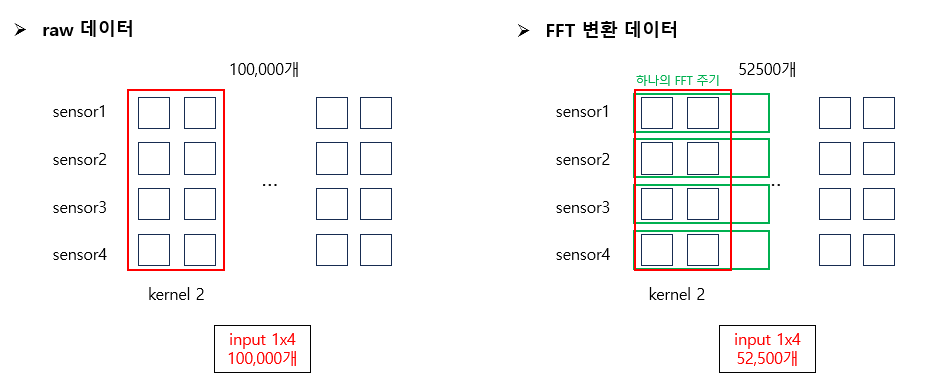

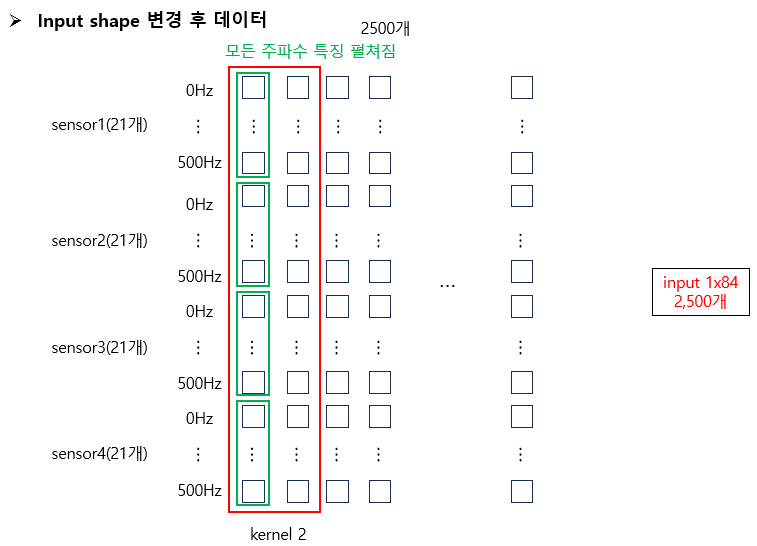

In [ ]:
n1 = normal_.iloc[:,0]
n2 = normal_.iloc[:,1]
n3 = normal_.iloc[:,2]
n4 = normal_.iloc[:,3]

n1 = n1.values.reshape((2500,21))
n2 = n2.values.reshape((2500,21))
n3 = n3.values.reshape((2500,21))
n4 = n4.values.reshape((2500,21))

n1 = pd.DataFrame(n1)
n2 = pd.DataFrame(n2)
n3 = pd.DataFrame(n3)
n4 = pd.DataFrame(n4)

normal_ = pd.concat([n1,n2,n3,n4],True)

normal_

<ipython-input-12-ec090b8a6773>:16: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  normal_ = pd.concat([n1,n2,n3,n4],True)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.376930,16.971189,4.058426,1.308825,0.645161,0.700917,0.840048,0.534764,1.262173,1.095530,...,3.094291,2.003500,0.256172,1.242266,0.969888,5.442303,3.052824,1.807772,2.202383,0.156847
1,0.188162,16.789169,3.007513,1.492986,0.742241,0.535933,2.407965,1.082204,1.140026,0.871089,...,0.880159,0.933185,1.598895,1.009475,0.757262,2.494041,2.014772,3.586223,2.981813,0.210335
2,0.931868,17.032963,1.959906,0.898628,1.692288,0.768562,1.740283,1.211054,1.749187,1.745704,...,2.424334,0.280406,0.852529,1.501543,2.124643,5.329392,1.191961,2.971661,0.899021,0.088229
3,2.002333,16.759948,4.061986,0.879645,0.644544,0.680991,1.332379,0.516128,0.701435,1.844749,...,2.089666,0.618716,0.939954,1.311021,1.611428,4.914763,2.360749,3.229424,1.634405,0.213136
4,1.905630,17.686120,1.870571,2.029032,0.936104,1.014954,1.206962,0.333010,0.499356,0.143374,...,0.305452,1.245281,1.265088,0.845273,1.296986,2.908485,0.973081,3.137096,2.737088,0.691115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1.980617,16.839722,4.264379,2.321765,0.774124,1.045286,0.638452,0.842964,1.040823,0.387839,...,0.436542,0.237822,0.769261,0.631499,2.629183,1.902973,1.909766,5.139090,1.677035,0.616385
2496,1.749614,17.090230,4.286565,1.244652,0.857671,0.550246,1.415509,0.586026,2.444091,2.046739,...,2.358536,0.279532,2.198205,1.881403,1.621515,4.989883,2.619550,1.404607,1.249890,0.928907
2497,1.732033,17.385159,4.062052,1.331996,0.917793,0.801888,0.417638,2.028755,1.055663,0.375506,...,0.893142,1.071582,1.755016,0.511097,1.544703,2.218928,0.767039,1.556272,3.203725,0.472528
2498,1.748796,17.122090,4.390226,0.772099,0.720773,0.586876,1.850208,1.432723,1.856220,2.169698,...,1.133107,1.274898,0.807365,1.091201,1.940820,1.124865,3.734006,0.545608,1.500232,0.363616


In [ ]:
t11 = type1_.iloc[:,0]
t12 = type1_.iloc[:,1]
t13 = type1_.iloc[:,2]
t14 = type1_.iloc[:,3]

t11 = t11.values.reshape((2500,21))
t12 = t12.values.reshape((2500,21))
t13 = t13.values.reshape((2500,21))
t14 = t14.values.reshape((2500,21))

t11 = pd.DataFrame(t11)
t12 = pd.DataFrame(t12)
t13 = pd.DataFrame(t13)
t14 = pd.DataFrame(t14)

type1_ = pd.concat([t11,t12,t13,t14],True)

type1_

<ipython-input-13-99cf37554a73>:16: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  type1_ = pd.concat([t11,t12,t13,t14],True)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.102482,42.382164,5.831833,2.643425,1.339637,1.609811,1.081140,1.776006,1.632187,0.543233,...,0.560022,2.147528,0.620223,1.434582,0.980540,6.241515,3.837205,3.386979,0.738362,1.148564
1,1.929929,42.484827,5.546589,3.347412,1.984595,1.366573,0.801296,1.061944,1.258262,0.978400,...,1.210398,0.823324,1.783384,1.231817,2.328075,1.892979,2.843275,3.106178,4.007372,0.050941
2,2.764403,42.491678,5.568577,2.341759,1.392259,1.392241,0.909711,0.753487,1.492756,1.590635,...,1.560421,1.385452,3.000803,1.282416,0.705705,4.002379,2.157741,2.776757,3.908925,2.124999
3,0.032058,44.565182,2.276559,0.840269,0.344239,1.740423,1.791738,1.862229,1.094993,1.051952,...,0.753620,1.484767,0.208291,2.571345,1.675738,4.107998,3.435601,2.811649,4.057858,0.477010
4,5.254560,45.424613,3.623278,0.707708,0.912648,0.494732,0.157421,0.602678,1.241948,0.777326,...,1.066312,0.573304,3.337460,1.295593,0.431296,6.766335,2.156793,0.298974,1.527459,1.889651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1.766847,44.199313,5.761071,2.694338,1.758951,1.732457,0.932051,1.392277,0.404238,0.296630,...,0.683505,0.823740,0.792407,1.774124,1.898250,3.587343,5.906874,3.356640,4.492275,0.934358
2496,0.350986,44.486784,6.705985,5.206279,1.324622,2.101004,0.101275,0.354773,1.730057,0.274473,...,0.502863,1.484847,1.248941,1.243443,0.181638,2.834980,5.057076,1.916832,3.562808,0.687855
2497,1.443063,44.772294,6.436876,2.182266,1.421756,1.371183,1.729263,0.681920,0.858891,0.900189,...,1.353500,1.433435,2.018930,1.100424,0.847226,5.988115,4.693912,4.403048,2.353823,0.053946
2498,3.648828,46.043101,5.597228,1.460480,1.358597,0.272225,0.414652,1.345651,0.246925,0.913823,...,1.121548,1.561885,2.127487,0.171370,1.412843,6.513811,2.938131,4.479654,3.475062,0.381394


In [ ]:
t21 = type2_.iloc[:,0]
t22 = type2_.iloc[:,1]
t23 = type2_.iloc[:,2]
t24 = type2_.iloc[:,3]

t21 = t21.values.reshape((2500,21))
t22 = t22.values.reshape((2500,21))
t23 = t23.values.reshape((2500,21))
t24 = t24.values.reshape((2500,21))

t21 = pd.DataFrame(t21)
t22 = pd.DataFrame(t22)
t23 = pd.DataFrame(t23)
t24 = pd.DataFrame(t24)

type2_ = pd.concat([t21,t22,t23,t24],True)

type2_

<ipython-input-14-6b9715660ba8>:16: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  type2_ = pd.concat([t21,t22,t23,t24],True)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,2.274328,17.339403,6.672578,1.973049,0.461895,1.147307,0.336830,1.396932,1.511488,1.035346,...,1.071811,0.258308,1.201785,0.869748,0.926242,1.778742,2.372486,1.890126,2.050131,0.485466
1,0.951682,17.066123,6.647263,3.418454,1.528256,1.098330,1.248189,1.559814,1.333654,0.573106,...,1.875048,1.534805,1.462175,3.220669,3.381921,1.072758,2.184273,3.055874,2.356276,1.811814
2,0.258676,16.674846,5.656658,1.441880,0.726263,0.650225,1.261512,1.203068,1.284541,2.603593,...,1.654028,0.262398,0.761630,1.615264,2.155611,2.175558,2.836971,1.808600,0.770968,0.992737
3,6.897818,15.727702,5.664688,2.915983,1.103033,0.999175,2.060018,2.568950,0.674184,1.336725,...,1.223324,0.967517,0.927982,1.460171,0.302318,3.392343,1.256283,1.174299,3.324783,0.843226
4,1.792478,17.638134,7.071360,0.772215,1.277166,1.008454,0.642010,0.862737,1.308164,1.735421,...,2.082193,1.714578,0.707461,0.491463,2.323722,1.596655,2.644107,0.409471,1.889611,1.495371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.418780,15.047234,7.983234,1.757868,0.901041,0.182401,1.169687,1.523943,1.276159,1.265036,...,0.685869,1.077570,1.729568,1.402195,1.635659,3.619720,4.226567,0.484608,1.445913,4.188412
2496,0.704341,15.928395,7.312108,2.460527,1.483995,1.391518,1.211681,2.115647,2.740872,0.196616,...,1.184617,1.676634,2.170371,0.590855,1.495977,3.143217,2.126655,1.763744,0.989541,1.135269
2497,0.801646,15.824773,7.327169,1.630402,0.644295,0.159949,1.247124,0.558263,2.739725,1.164629,...,1.089151,1.226993,0.738845,1.240475,1.223589,0.858275,2.973295,0.795730,3.947640,0.171722
2498,1.607497,16.374647,7.186236,1.362731,0.963592,0.974243,1.685591,1.387149,3.410983,0.764508,...,1.212572,1.701887,1.172621,2.816351,1.078249,3.948997,1.083262,1.632207,3.043068,1.424512


In [ ]:
t31 = type3_.iloc[:,0]
t32 = type3_.iloc[:,1]
t33 = type3_.iloc[:,2]
t34 = type3_.iloc[:,3]

t31 = t31.values.reshape((2500,21))
t32 = t32.values.reshape((2500,21))
t33 = t33.values.reshape((2500,21))
t34 = t34.values.reshape((2500,21))

t31 = pd.DataFrame(t31)
t32 = pd.DataFrame(t32)
t33 = pd.DataFrame(t33)
t34 = pd.DataFrame(t34)

type3_ = pd.concat([t31,t32,t33,t34],True)

type3_

<ipython-input-15-d71d46389e1f>:16: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  type3_ = pd.concat([t31,t32,t33,t34],True)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,3.253914,46.170761,10.882092,2.138766,0.831896,1.485704,1.033147,0.584710,1.345071,0.649593,...,0.494153,0.717779,1.738382,0.951682,2.186398,2.256154,1.199925,1.157084,1.629939,0.076767
1,4.199594,46.605368,11.248691,0.561848,1.218186,0.058018,0.880743,1.731585,0.453515,2.535998,...,1.186359,1.675151,1.448924,2.150300,1.633733,3.049820,4.608054,3.287635,2.650210,6.754659
2,4.231895,46.569404,11.352914,1.453406,0.593047,0.653615,0.712730,1.478264,1.678078,0.566725,...,1.614078,1.219443,0.399940,1.680104,1.125790,1.427080,3.852649,3.281015,1.508484,3.713640
3,7.435746,46.428626,14.586419,4.718038,1.896174,1.427075,2.611722,1.139606,1.159864,0.478537,...,1.825497,1.510793,0.429521,2.359426,0.827569,1.119364,5.340406,2.368294,1.321952,1.236692
4,2.678592,44.804229,10.954285,1.342030,0.654667,0.449226,1.566783,0.431377,3.681232,1.617282,...,2.615641,0.983351,1.662405,1.867453,1.311494,3.992303,3.167854,0.761569,1.720169,0.018033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,3.471695,45.223033,10.123489,0.323954,0.970963,0.467023,1.145187,1.003880,1.925929,0.560859,...,0.356249,1.042126,2.557406,2.355760,1.053578,1.215508,4.409329,1.402964,2.123356,1.069349
2496,2.775418,45.114636,10.646204,1.731283,0.721981,0.621232,0.720233,1.565009,2.672386,1.551899,...,0.850748,1.238015,0.797632,0.590084,0.646735,2.669194,3.185131,0.718511,2.998823,1.092580
2497,3.295479,44.957145,9.901499,1.025747,1.623549,0.695408,0.381218,1.584254,2.699248,0.492398,...,0.209402,0.478079,2.087750,2.401224,1.073170,0.673428,2.171653,2.002637,1.163477,1.765053
2498,2.732894,44.268265,11.656742,2.322648,0.633123,0.136378,0.700617,0.892579,3.718946,0.713974,...,1.827985,0.483156,1.031037,2.767366,0.727521,0.496454,1.257787,2.855952,1.916719,1.578352


FFT 변환 후 데이터 시각화

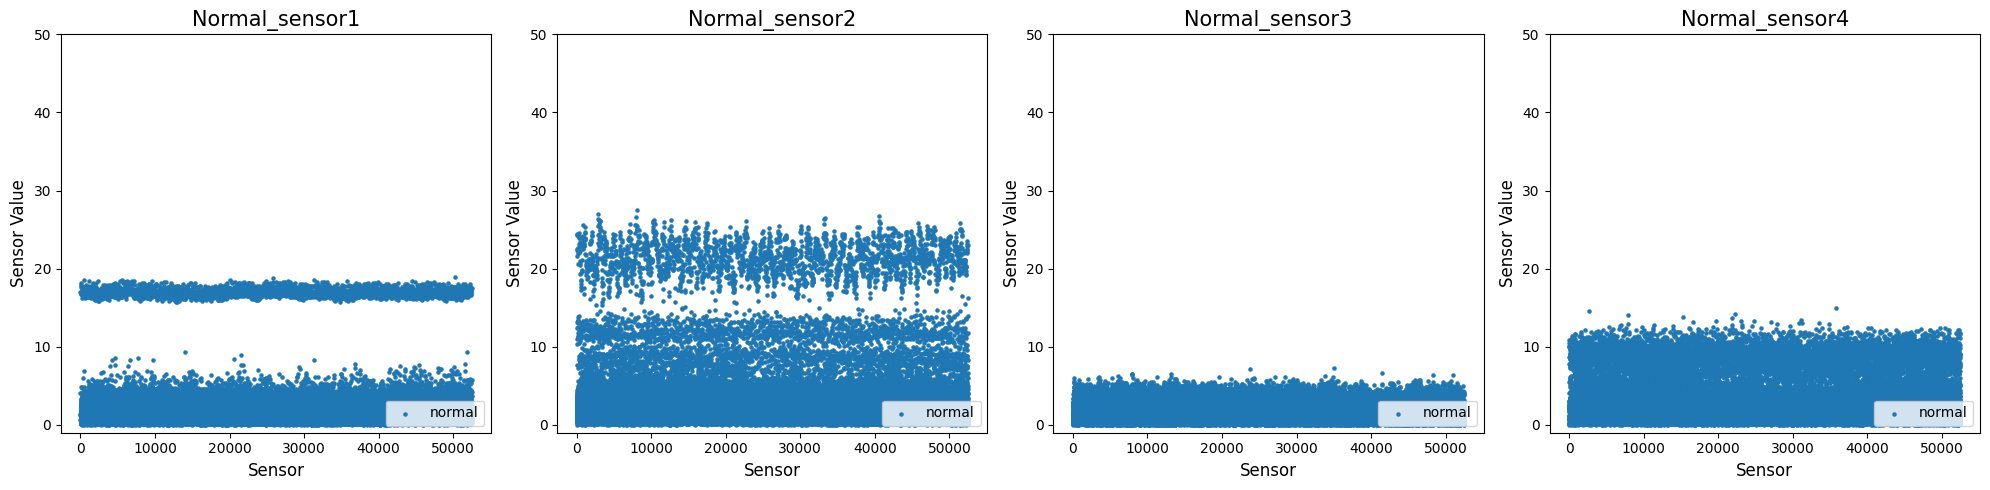

In [ ]:
# 그래프 그리기
plt.figure(figsize=(20, 5))

# 그래프 1
plt.subplot(1, 4, 1)
plt.scatter(range(len(normal['s1'])), normal['s1'], label="normal", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("Normal_sensor1", fontsize=15)

# 그래프 2
plt.subplot(1, 4, 2)
plt.scatter(range(len(type1['s1'])), normal['s2'], label="normal", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("Normal_sensor2", fontsize=15)

# 그래프 3
plt.subplot(1, 4, 3)
plt.scatter(range(len(type2['s1'])), normal['s3'], label="normal", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("Normal_sensor3", fontsize=15)

# 그래프 4
plt.subplot(1, 4, 4)
plt.scatter(range(len(type3['s1'])), normal['s4'], label="normal", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("Normal_sensor4", fontsize=15)

plt.tight_layout()
plt.show()

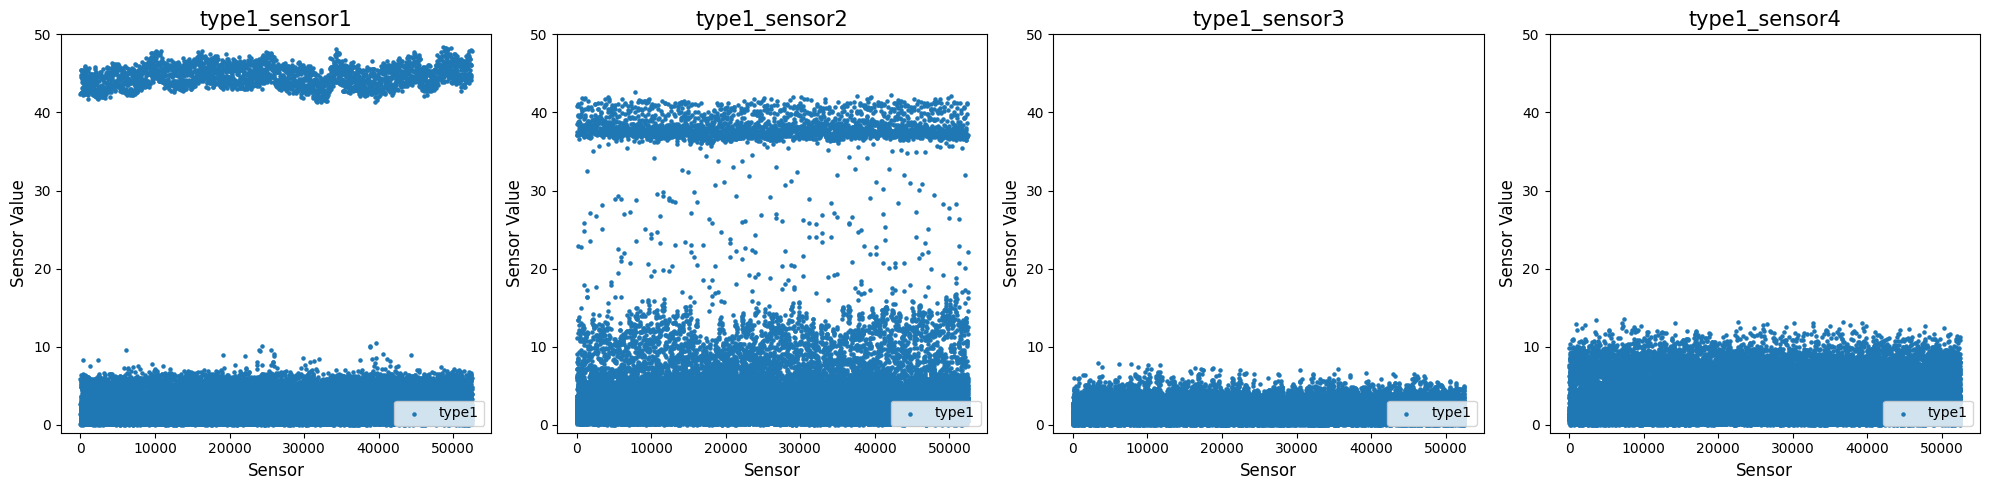

In [ ]:
# 그래프 그리기
plt.figure(figsize=(20, 5))

# 그래프 1
plt.subplot(1, 4, 1)
plt.scatter(range(len(type1['s1'])), type1['s1'], label="type1", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("type1_sensor1", fontsize=15)

# 그래프 2
plt.subplot(1, 4, 2)
plt.scatter(range(len(type1['s1'])), type1['s2'], label="type1", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("type1_sensor2", fontsize=15)

# 그래프 3
plt.subplot(1, 4, 3)
plt.scatter(range(len(type1['s1'])), type1['s3'], label="type1", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("type1_sensor3", fontsize=15)

# 그래프 4
plt.subplot(1, 4, 4)
plt.scatter(range(len(type1['s1'])), type1['s4'], label="type1", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("type1_sensor4", fontsize=15)

plt.tight_layout()
plt.show()

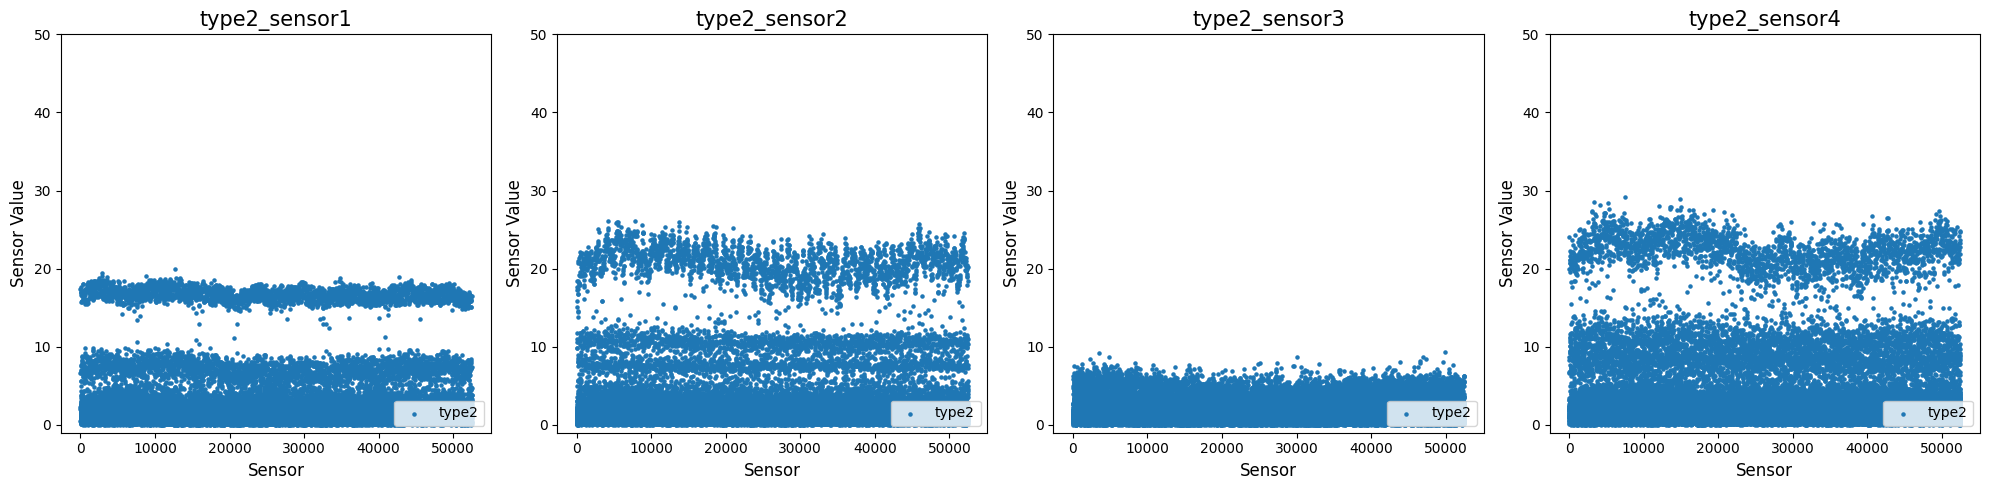

In [ ]:
# 그래프 그리기
plt.figure(figsize=(20, 5))

# 그래프 1
plt.subplot(1, 4, 1)
plt.scatter(range(len(type2['s1'])), type2['s1'], label="type2", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("type2_sensor1", fontsize=15)

# 그래프 2
plt.subplot(1, 4, 2)
plt.scatter(range(len(type2['s1'])), type2['s2'], label="type2", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("type2_sensor2", fontsize=15)

# 그래프 3
plt.subplot(1, 4, 3)
plt.scatter(range(len(type2['s1'])), type2['s3'], label="type2", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("type2_sensor3", fontsize=15)

# 그래프 4
plt.subplot(1, 4, 4)
plt.scatter(range(len(type2['s1'])), type2['s4'], label="type2", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("type2_sensor4", fontsize=15)

plt.tight_layout()
plt.show()

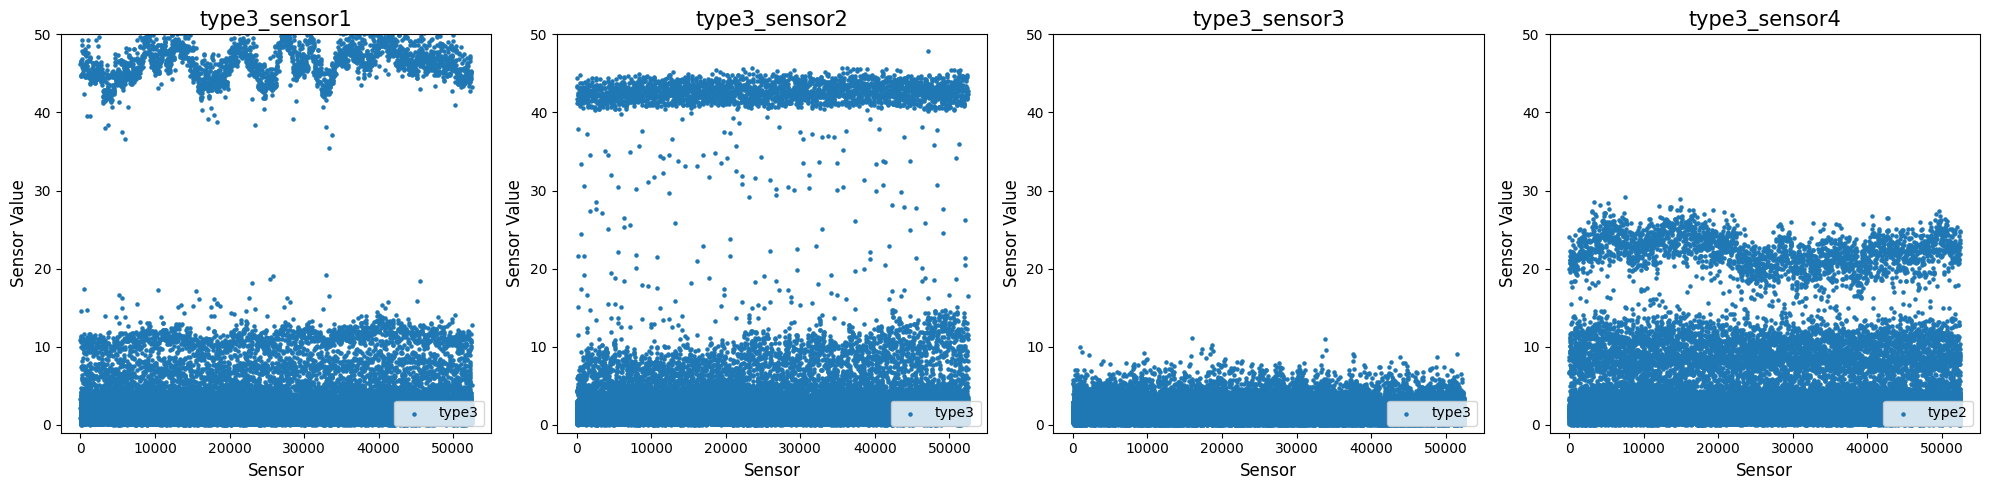

In [ ]:
# 그래프 그리기
plt.figure(figsize=(20, 5))

# 그래프 1
plt.subplot(1, 4, 1)
plt.scatter(range(len(type3['s1'])), type3['s1'], label="type3", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("type3_sensor1", fontsize=15)

# 그래프 2
plt.subplot(1, 4, 2)
plt.scatter(range(len(type3['s1'])), type3['s2'], label="type3", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("type3_sensor2", fontsize=15)

# 그래프 3
plt.subplot(1, 4, 3)
plt.scatter(range(len(type3['s1'])), type3['s3'], label="type3", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("type3_sensor3", fontsize=15)

# 그래프 4
plt.subplot(1, 4, 4)
plt.scatter(range(len(type2['s1'])), type2['s4'], label="type2", marker='o', s=5)
plt.ylim(-1, 50)
#plt.xlim(0,100)
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.title("type3_sensor4", fontsize=15)

plt.tight_layout()
plt.show()

Train / Validation / Test 데이터 6:2:2 분배

In [ ]:
# 데이터 분배 6:2:2
normal_train = normal_[:1500]
normal_valid = normal_[1500:2000]
normal_test = normal_[2000:]

type1_train = type1_[:1500]
type1_valid = type1_[1500:2000]
type1_test = type1_[2000:]

type2_train = type2_[:1500]
type2_valid = type2_[1500:2000]
type2_test = type2_[2000:]

type3_train = type3_[:1500]
type3_valid = type3_[1500:2000]
type3_test = type3_[2000:]

train = np.concatenate((normal_train, type1_train, type2_train, type3_train))
valid = np.concatenate((normal_valid, type1_valid, type2_valid, type3_valid))
test = np.concatenate((normal_test, type1_test, type2_test, type3_test))

print("train data의 형태:", train.shape)
print("valid data의 형태:", valid.shape)
print("test data의 형태:", test.shape)

train data의 형태: (6000, 84)
valid data의 형태: (2000, 84)
test data의 형태: (2000, 84)


라벨링

In [ ]:
train_label = np.concatenate((np.full((1500, 1), 0), np.full((1500, 1), 1),
                              np.full((1500, 1), 2), np.full((1500, 1), 3)))

valid_label = np.concatenate((np.full((500, 1), 0), np.full((500, 1), 1),
                              np.full((500, 1), 2), np.full((500, 1), 3)))

test_label = np.concatenate((np.full((500, 1), 0), np.full((500, 1), 1),
                             np.full((500, 1), 2), np.full((500, 1), 3)))

무작위 셔플

In [ ]:
idx = np.arange(train.shape[0]);
np.random.shuffle(idx);
train = train[:][idx];
train_label = train_label[:][idx]

idx_v = np.arange(valid.shape[0]);
np.random.shuffle(idx_v);
valid = valid[:][idx_v];
valid_label = valid_label[:][idx_v]

idx_t = np.arange(test.shape[0]);
np.random.shuffle(idx_t);
test = test[:][idx_t];
test_label = test_label[:][idx_t]

데이터 type을 tensor로 변경

In [ ]:
x_train = torch.from_numpy(train).float()
y_train = torch.from_numpy(train_label).float().T[0]
x_valid = torch.from_numpy(valid).float()
y_valid = torch.from_numpy(valid_label).float().T[0]
x_test = torch.from_numpy(test).float()
y_test = torch.from_numpy(test_label).float().T[0]

Batch size 600으로 훈련 데이터의 10분의 1로 설정

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train, batch_size =600, shuffle=True)
valid = TensorDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid, batch_size =len(x_valid), shuffle=False)
test = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test, batch_size =len(x_valid), shuffle=False)

CNN 신경망 설정

In [ ]:
class CNN(nn.Module):
 def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=100, kernel_size=2, stride=1, padding='same'),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=1, stride=1),
    nn.Dropout(p=0.2))

    self.conv2 = nn.Sequential(
    nn.Conv1d(in_channels=100, out_channels=100, kernel_size=2, stride=1, padding='same'),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=1, stride=1),
    nn.Dropout(p=0.2))

    self.conv3 = nn.Sequential(
    nn.Conv1d(in_channels=100, out_channels=100, kernel_size=2, stride=1, padding='same'),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=1, stride=1),
    nn.Dropout(p=0.2))

    self.conv4 = nn.Sequential(
    nn.Conv1d(in_channels=100, out_channels=4, kernel_size=2, stride=1, padding='same'),
    nn.BatchNorm1d(4),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=1, stride=1))

    self.final_pool = nn.AdaptiveAvgPool1d(1)
    self.linear = nn.Linear(4, 4)
 def forward(self, input):
    input = input.unsqueeze(1)
    out =self.conv1(input)
    out = self.conv2(out)
    out = self.conv3(out)
    out =self.conv4(out)
    out =self.final_pool(out)
    out =self.linear(out.squeeze(-1))
    return out
model_check = CNN()
print(model_check)

CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 100, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv4): Seque

훈련 알고리즘

In [ ]:
def train_model(model, criterion, optimizer, num_epoch, train_dataloader, PATH):
  loss_values = []
  loss_values_v = []
  accuracy_values = []  ### 추가한 부분
  accuracy_values_v = []
  check =0; accuracy_past =0
  for epoch in range(1, num_epochs +1):
 #---------------------- 모델 학습 ---------------------#
    model.train()
    batch_number =0
    running_loss =0.0
    train_accuracy =0.0
    train_total =0.0
    for batch_idx, samples in enumerate(train_dataloader):
      x_train, y_train = samples

      optimizer.zero_grad()
      y_hat = model.forward(x_train)
      loss = criterion(y_hat,y_train.long())
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      batch_number +=1

      _, predicted_train = torch.max(y_hat.data, 1)
      train_total += y_train.size(0)
      train_accuracy += (predicted_train == y_train).sum().item()

    loss_values.append(running_loss / batch_number)
    train_accuracy = (train_accuracy / train_total)
    accuracy_values.append(train_accuracy)
 #------------------------------------------------------#
 #---------------------- 모델 검증 ---------------------#
    model.eval()
    accuracy =0.0
    total =0.0
    for batch_idx, data in enumerate(valid_dataloader):
      x_valid, y_valid = data

      v_hat = model.forward(x_valid)
      v_loss = criterion(v_hat,y_valid.long())
      _, predicted = torch.max(v_hat.data, 1)
      total += y_valid.size(0)
      accuracy += (predicted == y_valid).sum().item()
    loss_values_v.append(loss.item())
    valid_accuracy = (accuracy / total)
    accuracy_values_v.append(valid_accuracy)  ### 추가한 부분
 #------------------------------------------------------#
 #----------------Check for early stopping---------------#
    if epoch % 1 ==0:
      print('[Epoch {}/{}] [Train_Loss: {:.6f} /Valid_Loss: {:.6f}]'.format(epoch, num_epochs, loss.item(),v_loss.item()))
      print('[Epoch {}/{}] [Train_Accuracy : {:.6f} /Valid_Accuracy : {:.6f}]'.format(epoch, num_epochs, train_accuracy, valid_accuracy))

    if accuracy_past > accuracy:
      check +=1
    else:
      check =0
      accuracy_past = accuracy

    if check >50:
      print('This is time to do early stopping')

  torch.save(model, PATH +'model.pt')
  return loss_values, loss_values_v, accuracy_values, accuracy_values_v

In [ ]:
# 원본 데이터셋에서 입력 데이터 가져오기
original_data = train_dataloader.dataset.tensors[0]
original_labels = train_dataloader.dataset.tensors[1]

# 기존의 TensorDataset과 동일한 데이터셋 생성
new_train_dataset = TensorDataset(original_data, original_labels)
new_train_dataloader = DataLoader(new_train_dataset, batch_size=600, shuffle=True)

학습 시작

In [ ]:
CNN_model = CNN()
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters())
PATH ='/content/drive/MyDrive/디스커버리_프로그래밍대회'
CNN_loss_values, CNN_loss_values_v, CNN_accuracy_values, CNN_accuracy_values_v = train_model(CNN_model, criterion, optimizer, num_epochs, new_train_dataloader, PATH)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


[Epoch 1/50] [Train_Loss: 1.387040 /Valid_Loss: 1.404136]
[Epoch 1/50] [Train_Accuracy : 0.332167 /Valid_Accuracy : 0.252500]
[Epoch 2/50] [Train_Loss: 1.362905 /Valid_Loss: 1.360409]
[Epoch 2/50] [Train_Accuracy : 0.448167 /Valid_Accuracy : 0.454000]
[Epoch 3/50] [Train_Loss: 1.349540 /Valid_Loss: 1.325170]
[Epoch 3/50] [Train_Accuracy : 0.444000 /Valid_Accuracy : 0.468000]
[Epoch 4/50] [Train_Loss: 1.339049 /Valid_Loss: 1.304568]
[Epoch 4/50] [Train_Accuracy : 0.453167 /Valid_Accuracy : 0.383000]
[Epoch 5/50] [Train_Loss: 1.286376 /Valid_Loss: 1.297948]
[Epoch 5/50] [Train_Accuracy : 0.457333 /Valid_Accuracy : 0.452000]
[Epoch 6/50] [Train_Loss: 1.291155 /Valid_Loss: 1.288081]
[Epoch 6/50] [Train_Accuracy : 0.468667 /Valid_Accuracy : 0.477000]
[Epoch 7/50] [Train_Loss: 1.264237 /Valid_Loss: 1.281744]
[Epoch 7/50] [Train_Accuracy : 0.477500 /Valid_Accuracy : 0.453500]
[Epoch 8/50] [Train_Loss: 1.254016 /Valid_Loss: 1.257496]
[Epoch 8/50] [Train_Accuracy : 0.474333 /Valid_Accuracy : 0.

테스트 알고리즘

In [ ]:
def test_model(model, PATH):
 model = torch.load(PATH +'model.pt')
 #---------------------- 모델 시험 ---------------------#
 model.eval()
 total =0.0
 accuracy =0.0
 for batch_idx, data in enumerate(test_dataloader):
    x_test, y_test = data

    t_hat = model(x_test)
    _, predicted = torch.max(t_hat.data, 1)
    total += y_test.size(0)
    accuracy += (predicted == y_test).sum().item()
    accuracy = (accuracy / total)
 #------------------------------------------------------#
 print(accuracy)

Confusion matrix 시각화 알고리즘

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def draw_confusion_matrix(model, xt, yt, PATH):
 y_pred = []; y_true = []
 model.eval()
 y_hat = model(xt); output = (torch.max(torch.exp(y_hat), 1)[1]).data.cpu().numpy()
 y_pred.extend(output)
 labels = y_test.data.cpu().numpy()
 y_true.extend(labels)
 # 분류 항목
 classes = ('Normal', 'Type1', 'Type2', 'Type3')
 # Confussion Matrix 생성
 plt.figure(figsize = (7,5))
 dlen = float(len(x_test))
 cm = confusion_matrix(y_true, y_pred)
 df_cm = pd.DataFrame(cm/dlen, index = [i for i in classes],columns = [i for i in classes])
 sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
 plt.title("Confusion Matrix", size=24, fontweight='bold')
 plt.xlabel("Predicted Label", size=16); plt.ylabel("Actual Label", size=16)
 plt.rc('xtick', labelsize=12); plt.rc('ytick', labelsize=12); plt.yticks(rotation=0)
 plt.savefig(PATH +'cm_output.png')

정확도 그래프 함수

In [ ]:
def plot_accuracy_graph(accuracy_values, accuracy_values_v):
 plt.figure()
 plt.plot(accuracy_values)
 plt.plot(accuracy_values_v)
 plt.title("Training & Validation Accuracy")
 plt.ylabel("accuracy", fontsize="large")
 plt.xlabel("epoch", fontsize="large")
 plt.legend(["train", "validation"])
 plt.tight_layout()
 plt.savefig(PATH +'lossplot_output.png')

손실 그래프 함수

In [ ]:
def plot_loss_graph(loss_values, loss_values_v):
 plt.figure()
 plt.plot(loss_values)
 plt.plot(loss_values_v)
 plt.title("Training & Validation Loss")
 plt.ylabel("loss", fontsize="large")
 plt.xlabel("epoch", fontsize="large")
 plt.legend(["train", "validation"])
 plt.tight_layout()
 plt.savefig(PATH +'lossplot_output.png')

정확도 출력

In [ ]:
PATH ='/content/drive/MyDrive/디스커버리_프로그래밍대회'
test_model(CNN_model, PATH)

0.998


Confusion matrix 출력

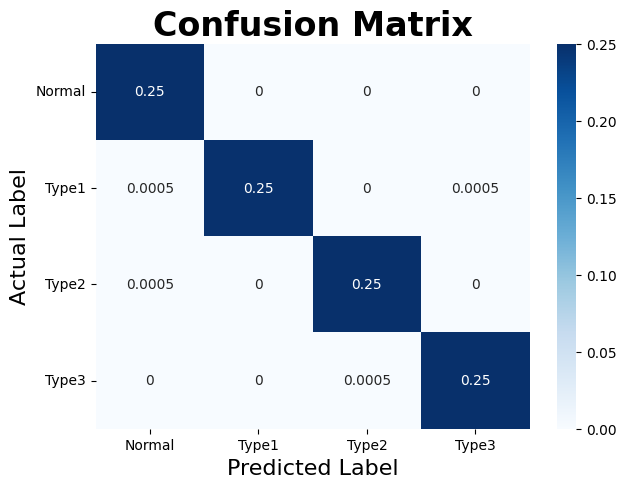

In [ ]:
draw_confusion_matrix(model=CNN_model, xt=x_test, yt=y_test, PATH=PATH)

정확도 그래프 출력

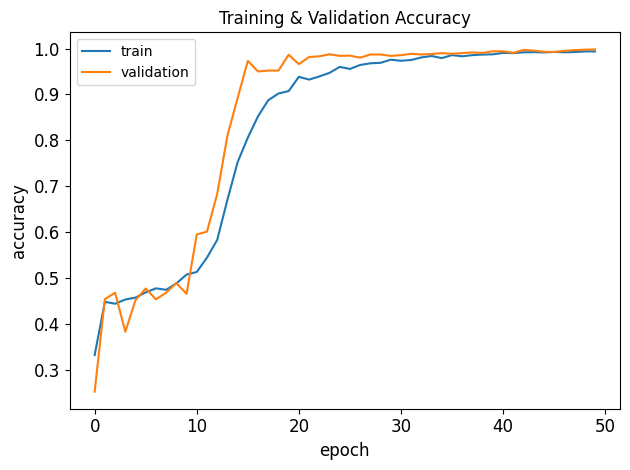

In [ ]:
plot_accuracy_graph(CNN_accuracy_values, CNN_accuracy_values_v)

손실 그래프 출력

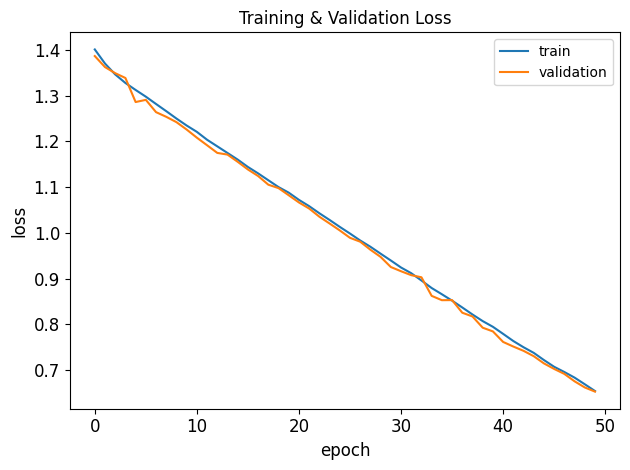

In [ ]:
plot_loss_graph(CNN_loss_values, CNN_loss_values_v)